# Data Loading

In [1]:
import torchvision
import torch
from torch import nn,optim
from torchvision import datasets,transforms

from __future__ import print_function
import time
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

In [2]:
batch_size=12

train_data = datasets.MNIST('D:\datasets', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('D:\datasets', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Model

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.in_dim = 28*28
        self.out_dim = 10
        
        self.fc1 = nn.Linear(self.in_dim,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,self.out_dim)
        
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax()
    def forward(self,x):
        z1 = self.fc1(x.view(-1, self.in_dim))
        a1 = self.relu(z1)
        z2 = self.fc2(a1)
        a2 = self.relu(z2)
        a3 = self.relu(self.fc3(a2))
        a4 = self.relu(self.fc4(a3))
        logit = self.fc5(a4)
        return logit, (z1,a1,z2,a2)

# Train

In [4]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [5]:
# z1,a1,z2,a2를 저장할 torch
z1 = torch.Tensor([])
a1 = torch.Tensor([])
z2 = torch.Tensor([])
a2 = torch.Tensor([])
y = torch.Tensor([])

In [6]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs, t = model(inputs)

        if (epoch == 9):
            z1 = torch.cat((t[0],z1),0)
            a1 = torch.cat((t[1],a1),0)
            z2 = torch.cat((t[2],z2),0)
            a2 = torch.cat((t[3],a2),0)
            y = torch.cat((labels,y),0)
           
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i+1) % 2000 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.222
[1,  4000] loss: 0.775
[2,  2000] loss: 0.322
[2,  4000] loss: 0.229
[3,  2000] loss: 0.163
[3,  4000] loss: 0.135
[4,  2000] loss: 0.105
[4,  4000] loss: 0.101
[5,  2000] loss: 0.078
[5,  4000] loss: 0.077
[6,  2000] loss: 0.055
[6,  4000] loss: 0.063
[7,  2000] loss: 0.046
[7,  4000] loss: 0.049
[8,  2000] loss: 0.034
[8,  4000] loss: 0.038
[9,  2000] loss: 0.029
[9,  4000] loss: 0.029
[10,  2000] loss: 0.025
[10,  4000] loss: 0.022
Finished Training


In [7]:
print("z1.shape :",z1.shape)
print("a1.shape :",a1.shape)
print("z2.shape :",z2.shape)
print("a2.shape :",a2.shape)

z1.shape : torch.Size([60000, 512])
a1.shape : torch.Size([60000, 512])
z2.shape : torch.Size([60000, 256])
a2.shape : torch.Size([60000, 256])


# Test

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

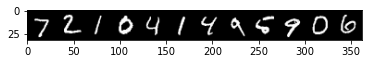

GroundTruth
    7   2   1   0   4   1   4   9   5   9   0   6
Prediction
    7   2   1   0   4   1   4   9   5   9   0   6


In [9]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow=batch_size))
print('GroundTruth')
print("  "+' '.join('%3s' % label.item() for label in labels))

outputs ,_ = model(images)
_,predicted = torch.max(outputs,1)
print("Prediction")
print("  "+' '.join('%3s' % label.item() for label in predicted))

In [10]:
n_predict = 0
n_correct = 0

for data in test_loader:
    inputs, labels = data
    outputs,_ = model(inputs)
    _,predicted = torch.max(outputs,1)
    
    n_predict += len(predicted)
    n_correct += (labels == predicted).sum()

print(f"{n_correct}/{n_predict}")
print(f"Accuracy: {n_correct/n_predict:.3f}")

9779/10000
Accuracy: 0.978


# Visualization

In [11]:
def draw(X,y):
    X = (X.data.view(-1,X.data.shape[1]) / 255.0).numpy()
    y = y.numpy()
    print("X.shape :",X.shape)
    print("y.shape :",y.shape)
    
    feat_cols = [f'pixel{i}' for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=feat_cols)
    df['y'] = y
    
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])
    print("rndperm :",rndperm)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df[feat_cols].values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(13,9))
    sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="y",
        palette=sns.color_palette("hls",10),
        data=df.loc[rndperm,:],
        legend="full",
        alpha=0.3
    )
    
    N = 10000
    df_subset = df.loc[rndperm[:N],:].copy()
    data_subset = df_subset[feat_cols].values
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_subset)
    df_subset['pca-one'] = pca_result[:,0]
    df_subset['pca-two'] = pca_result[:,1]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    time_start = time.time()
    tsne = TSNE(n_components=2,verbose=1,perplexity=40,n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    plt.figure(figsize=(13,9))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls",10),
        data=df_subset,
        legend="full",
        alpha=0.3
    )
    plt.show()

X.shape : (60000, 784)
y.shape : (60000,)
rndperm : [12628 37730 39991 ...   860 15795 56422]
Explained variation per principal component: [0.09704707 0.07095962]
Explained variation per principal component: [0.09614986 0.07138541]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 2.941s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed cond

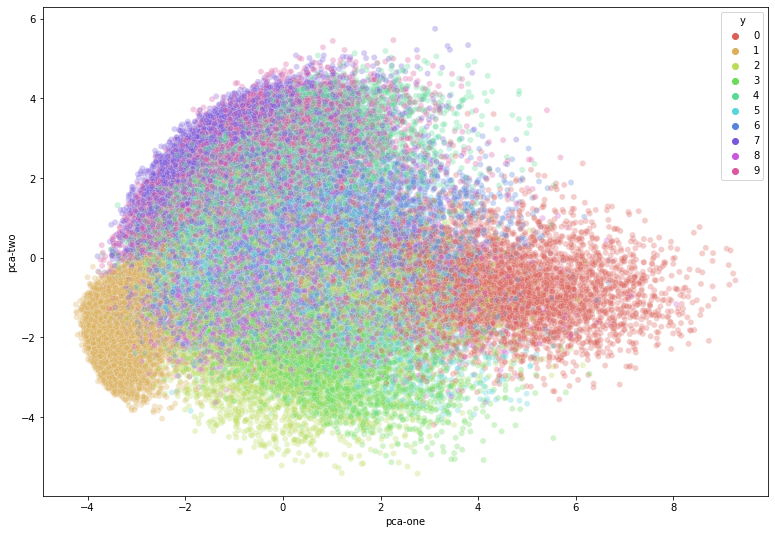

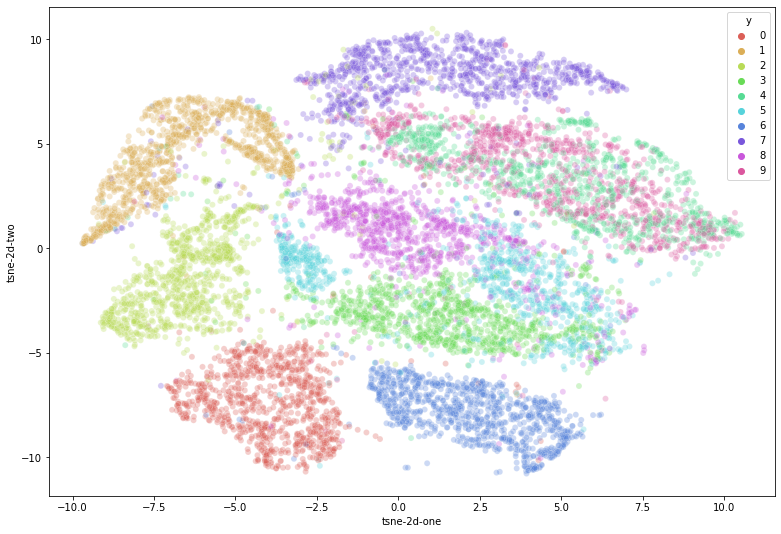

In [12]:
train_data.data = train_data.data.reshape(60000,784)
draw(train_data.data,train_data.targets)

X.shape : (60000, 512)
y.shape : (60000,)
rndperm : [12628 37730 39991 ...   860 15795 56422]
Explained variation per principal component: [0.16307725 0.12779094]
Explained variation per principal component: [0.16842291 0.12807901]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 2.863s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed cond

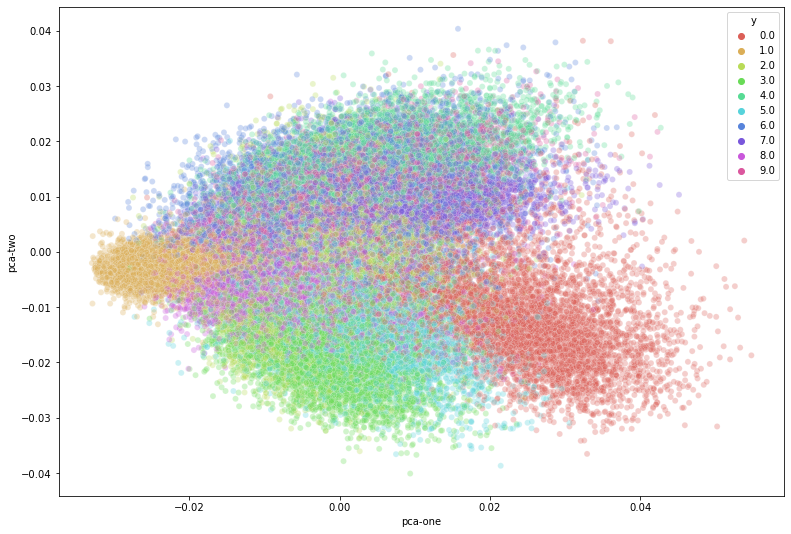

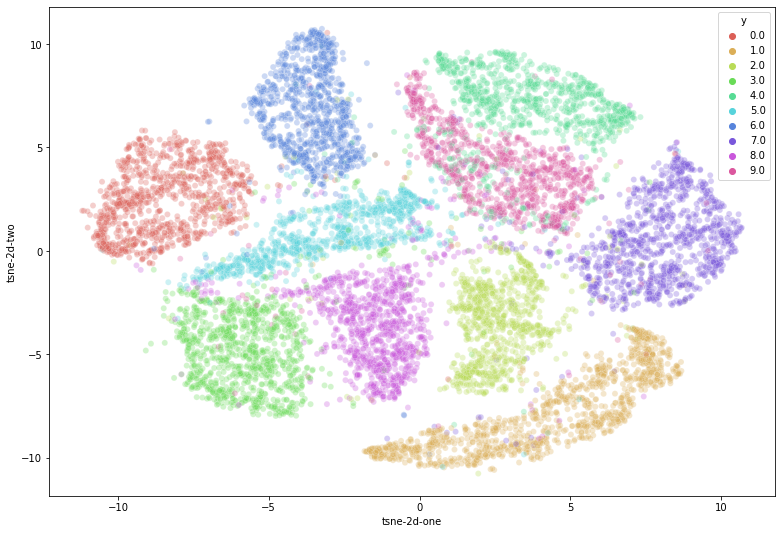

In [13]:
draw(z1,y)

X.shape : (60000, 512)
y.shape : (60000,)
rndperm : [12628 37730 39991 ...   860 15795 56422]
Explained variation per principal component: [0.12539092 0.0997327 ]
Explained variation per principal component: [0.12896086 0.10029887]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 2.922s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed cond

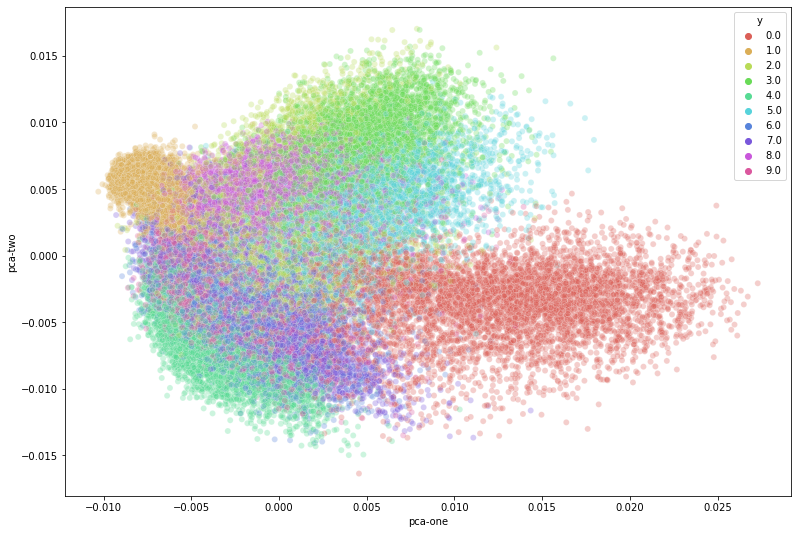

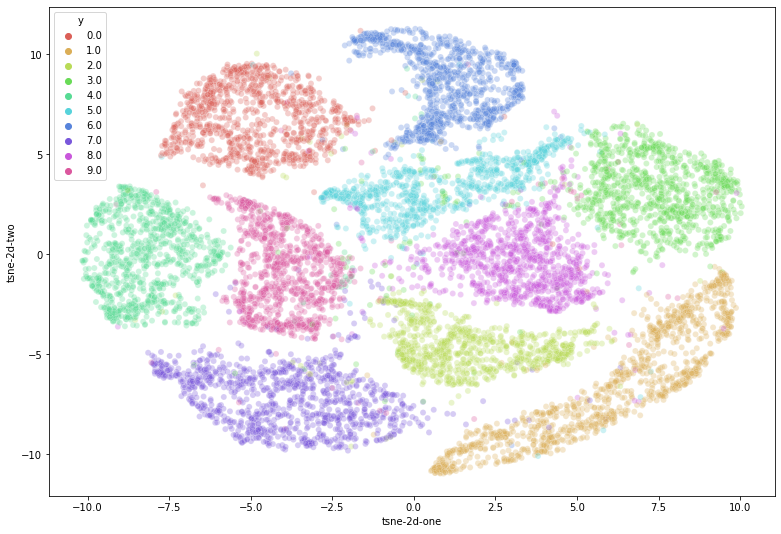

In [14]:
draw(a1,y)

X.shape : (60000, 256)
y.shape : (60000,)
rndperm : [12628 37730 39991 ...   860 15795 56422]
Explained variation per principal component: [0.2194095  0.19154203]
Explained variation per principal component: [0.22315946 0.1926389 ]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 2.603s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed cond

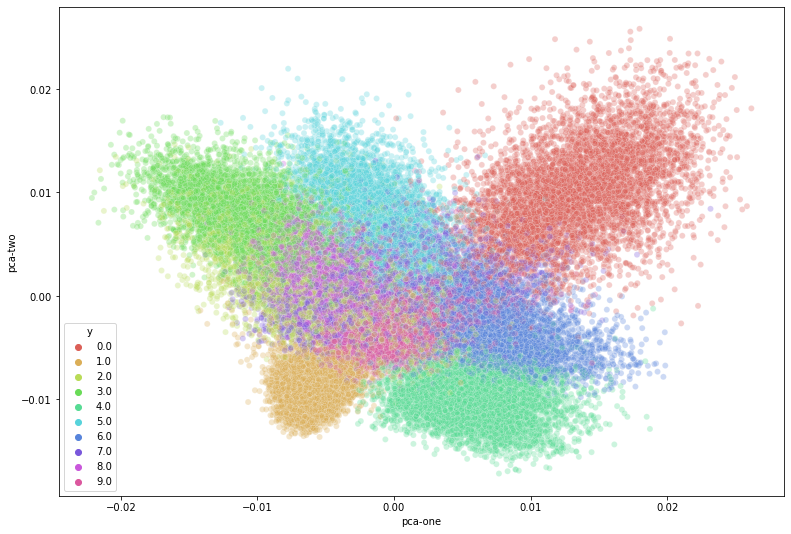

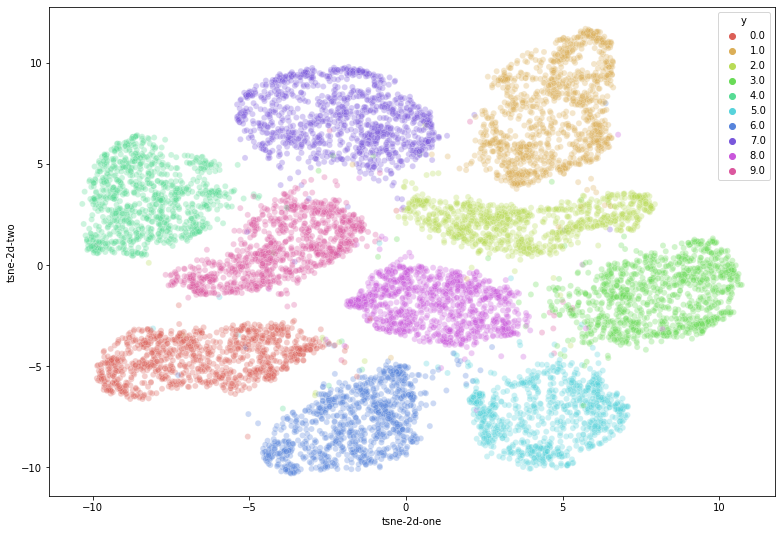

In [15]:
draw(z2,y)

X.shape : (60000, 256)
y.shape : (60000,)
rndperm : [12628 37730 39991 ...   860 15795 56422]
Explained variation per principal component: [0.21618882 0.18927912]
Explained variation per principal component: [0.22053196 0.18889758]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 2.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed cond

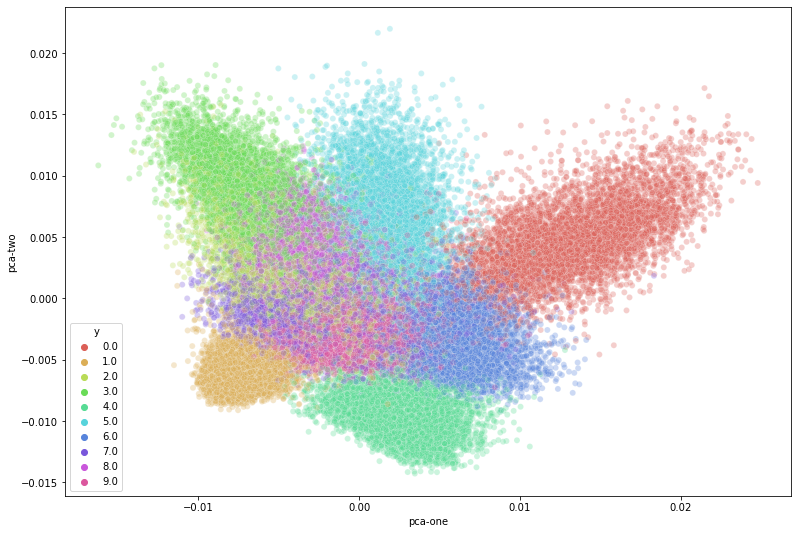

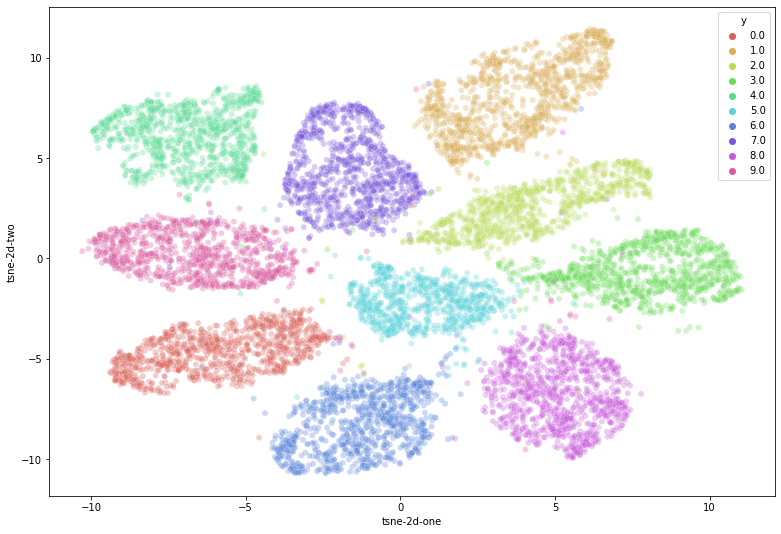

In [16]:
draw(a2,y)